In [2]:
import os
import sys
import exportCSV
import NPC 
import NPC_plotting

In [3]:
data_dir = '/home/maria/Documents/NPCPython/deletemedata2/' # Directory for output files
config = 'config.yaml'
histdata = 2

In [4]:
var = NPC.variables2(config)


var["n"] = 9 # Number of NPCs to be simulated
NPCi = 0 # index of NPC to be shown in any detail-plot or animation 
var["seed"] = 51234 #seed for reproducibility. Any number but 0


var["nup"] = ("nup107",)#, "Nup107", "Nup155")
var["term"] = ("C",)#, "N", "N") #TODO: Force proper syntax. Issues without trailing comma and rel = True
var["model"] = "7r5k"


# ############################
# # Variability parameters
var["mag"] = 15 # Magnitude of irregular variability. 0: No deformation, 15: Strong deformation
var["zmag"] = var["mag"]/2 # magnitude of offset in z. Not computed via springs 


if type(var["nup"]) == str: var["nup"] = tuple([var["nup"]])
if type(var["term"]) == str: var["term"] = tuple(["term"])


In [6]:
NPCstest = NPC.getNPCs(var) # 
NPCscoords = NPC.getNPCcoords(NPCstest, var) 

OffsetNPCs = NPC_plotting.OffsetNPCs(NPCscoords, 80)

/home/maria/Documents/NPCpy/NPCpy/DeformNPC.py:260: RuntimeWarning: invalid value encountered in divide
  return K/Lscale
/home/maria/Documents/NPCpy/NPCpy/DeformNPC.py:260: RuntimeWarning: invalid value encountered in divide
  return K/Lscale


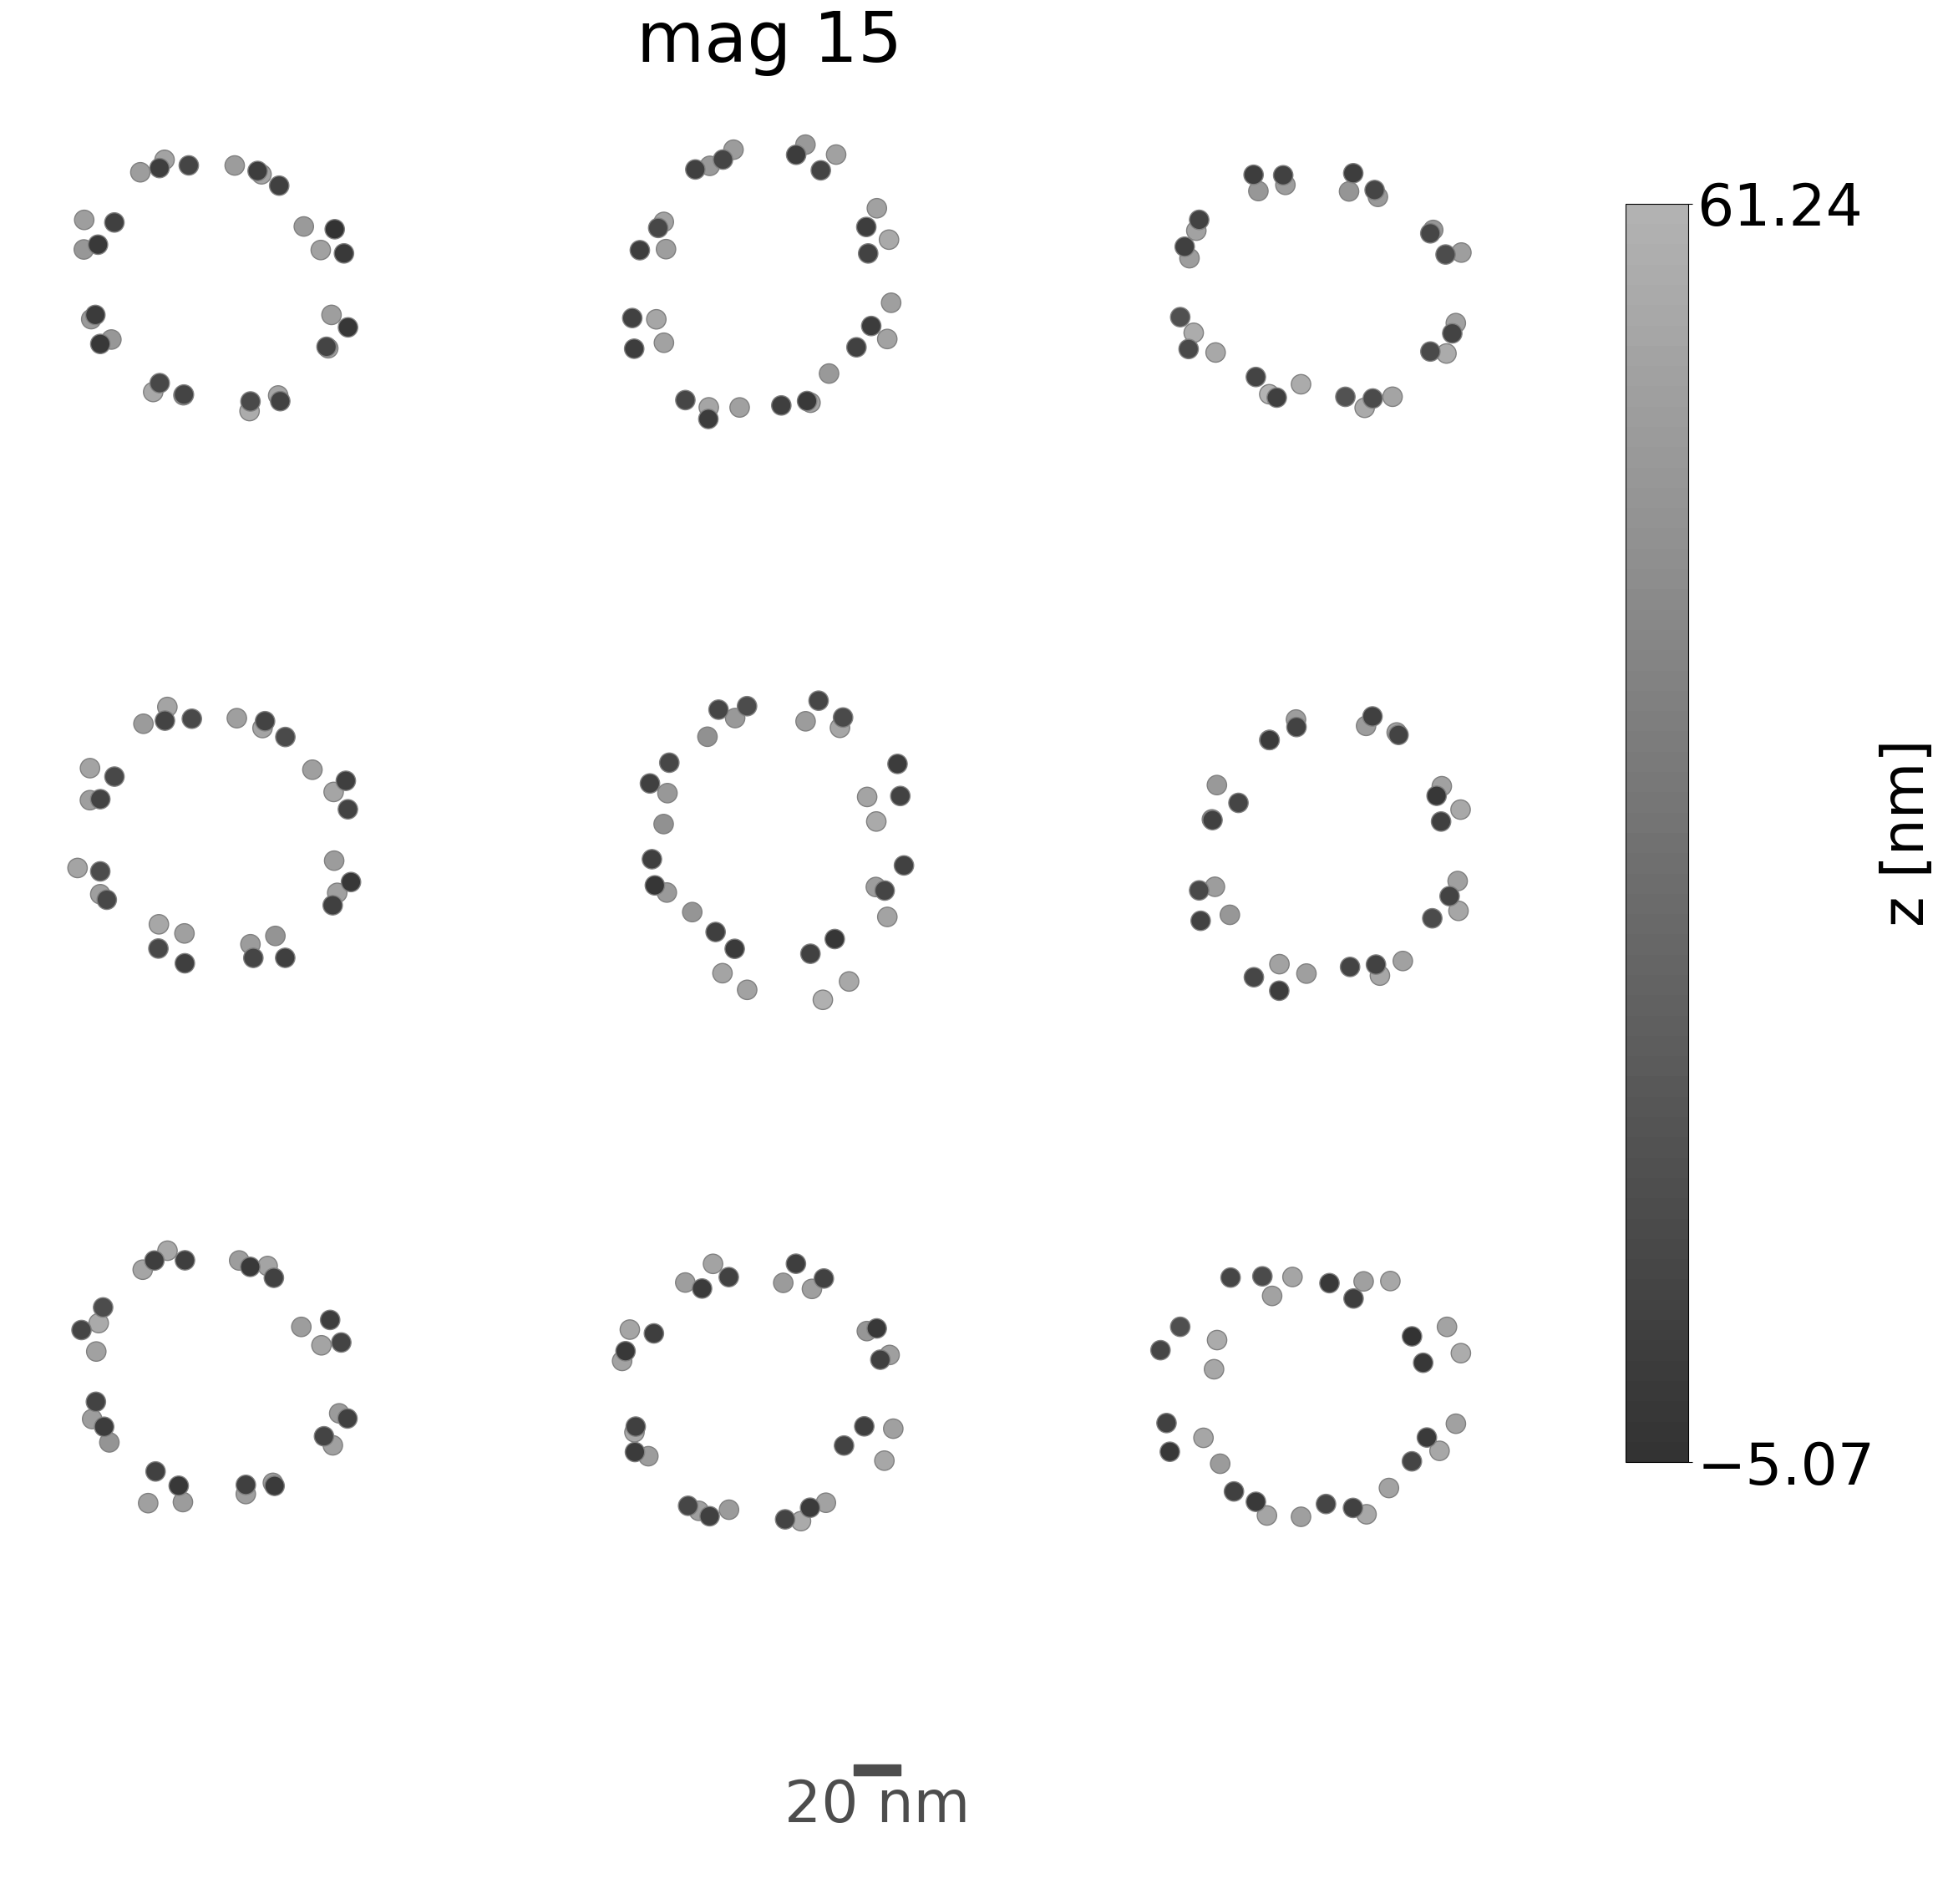

In [8]:
NPC_plotting.plotOverview(OffsetNPCs, NPCstest, var)

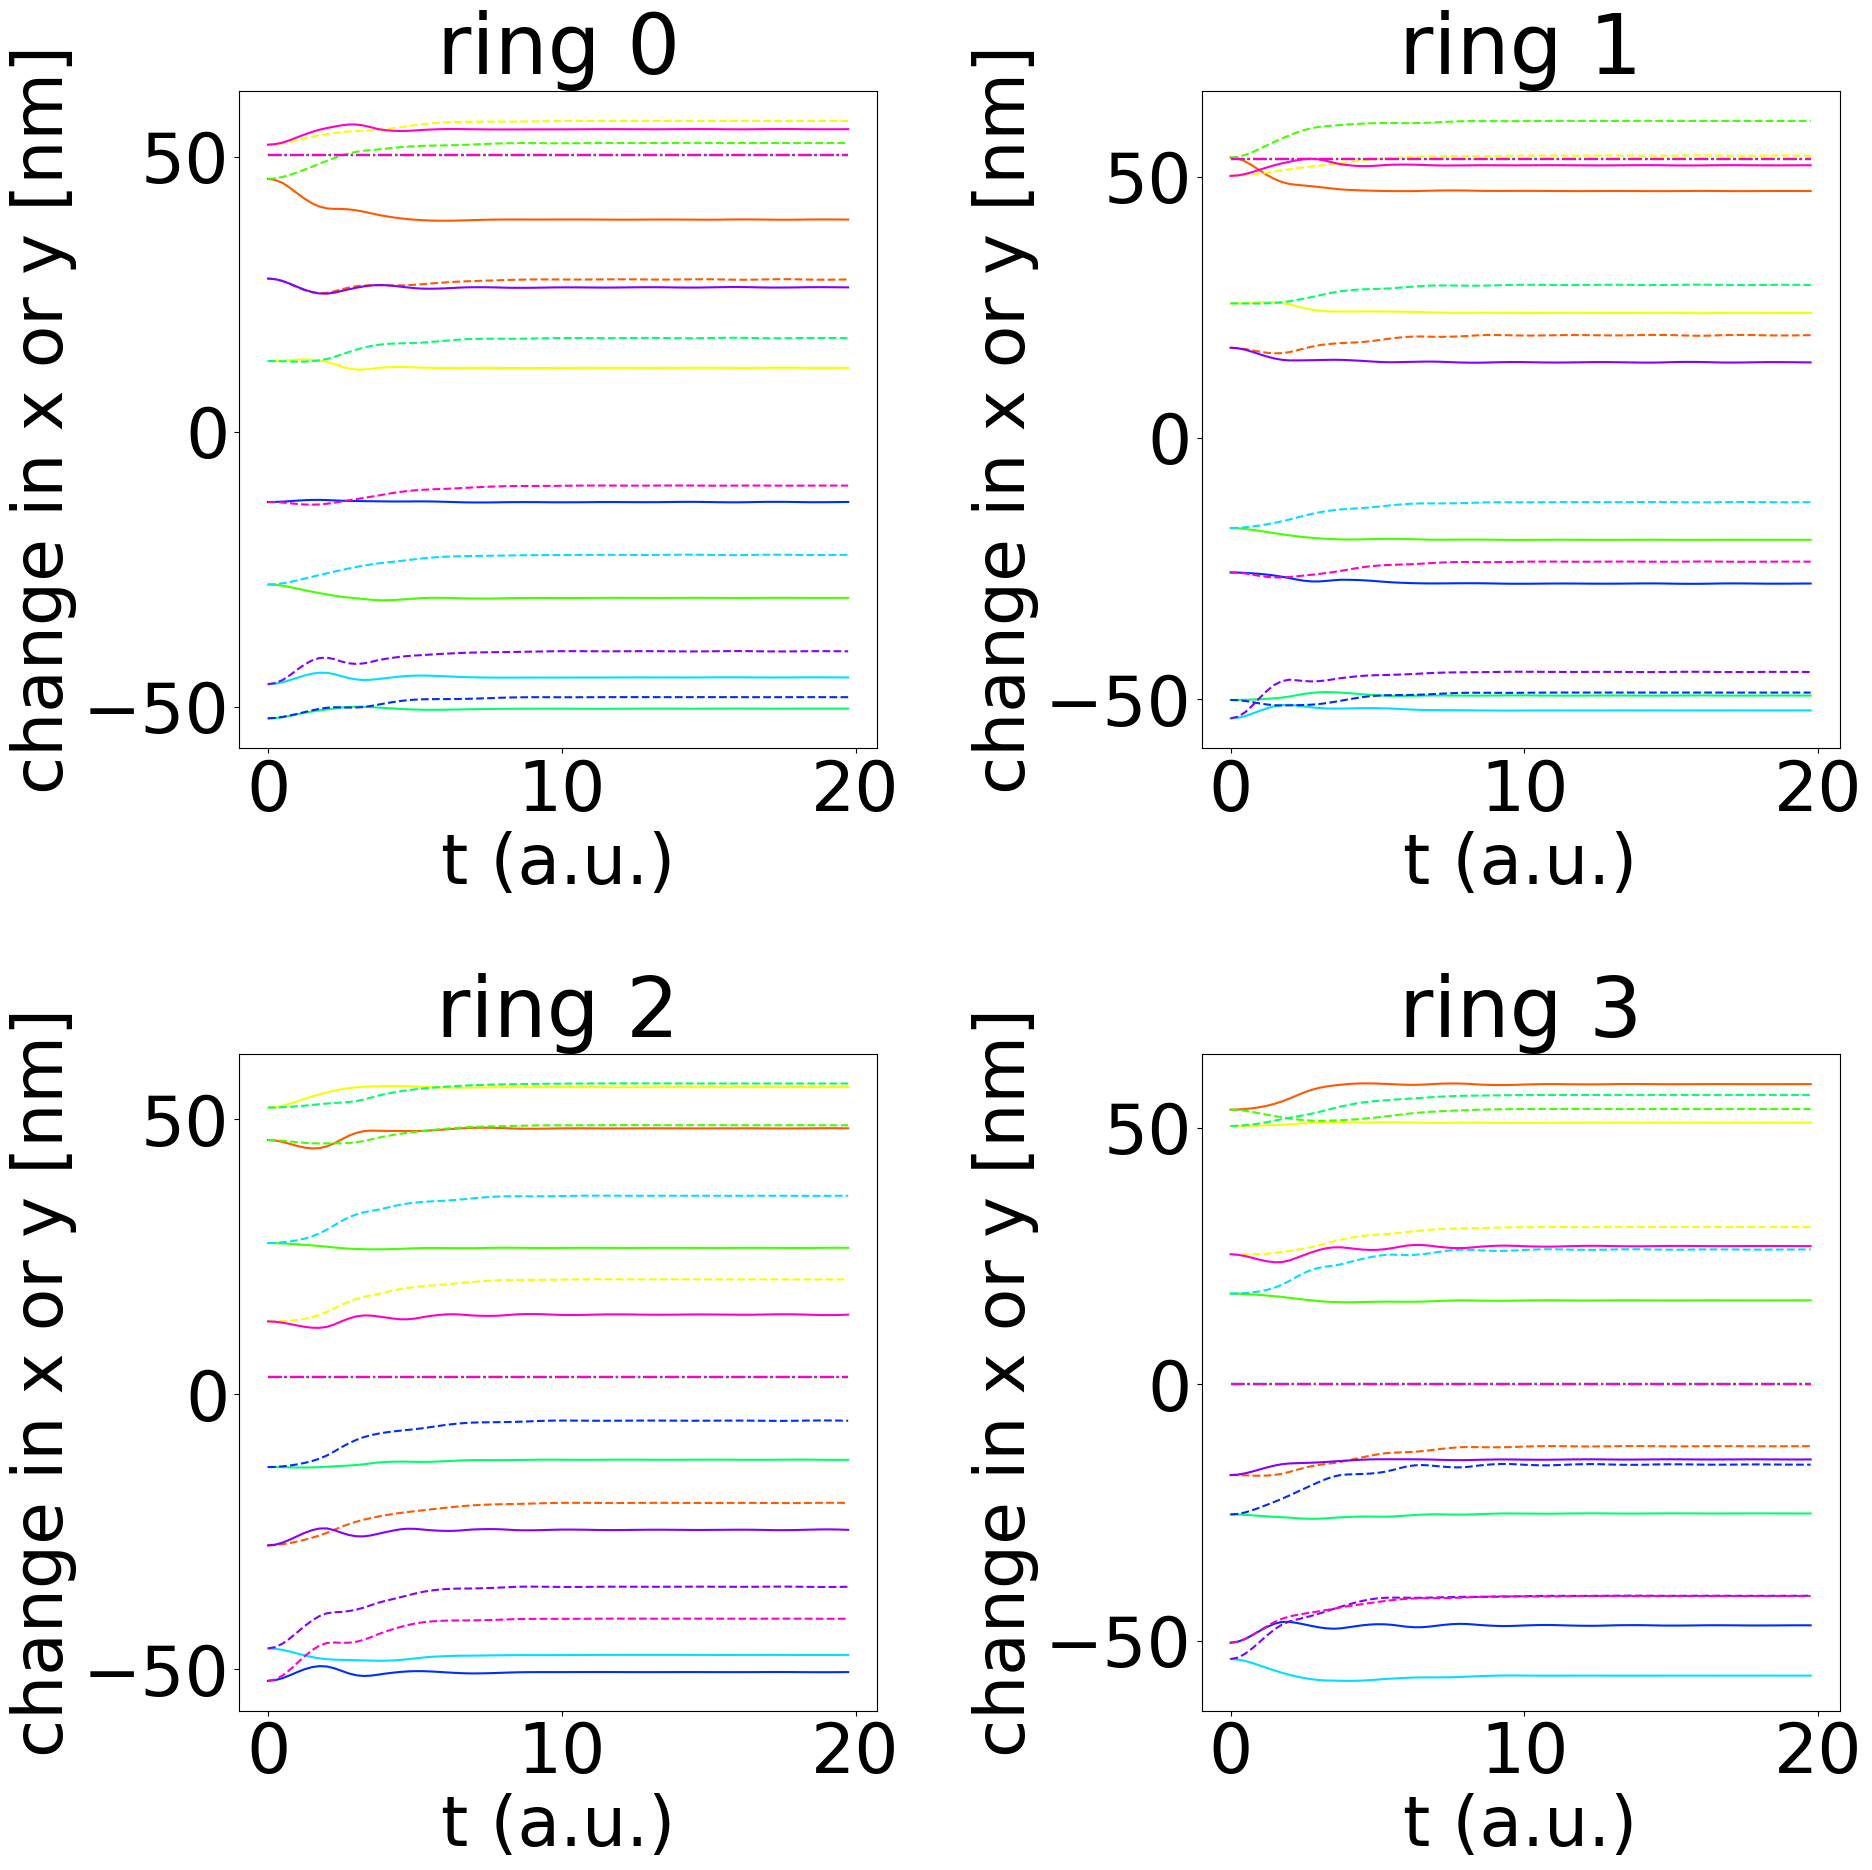

In [9]:
NPC_plotting.positionVStime(NPCstest, var, 0)

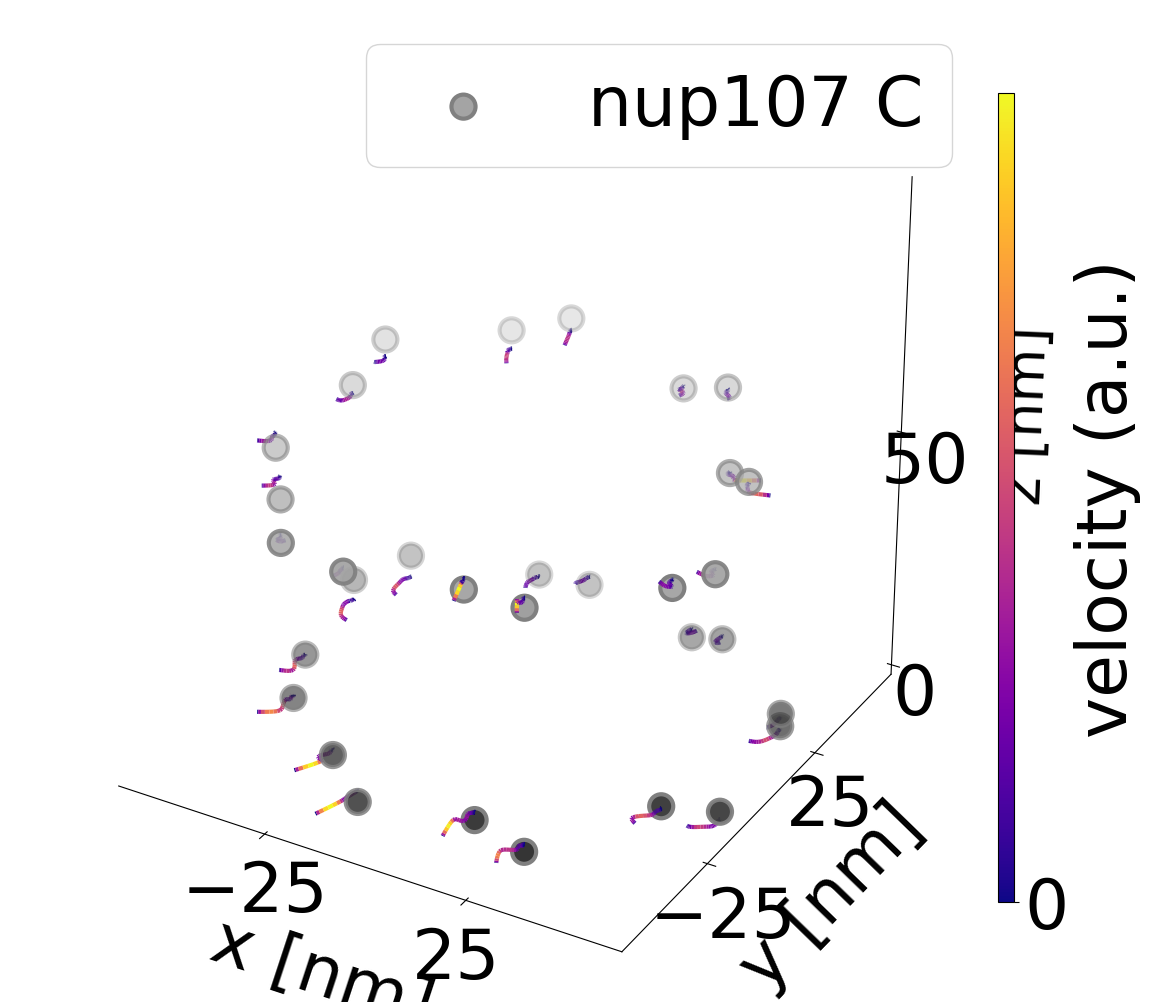

In [10]:
NPC_plotting.plotDetail(NPCscoords, NPCstest, var, NPCi)

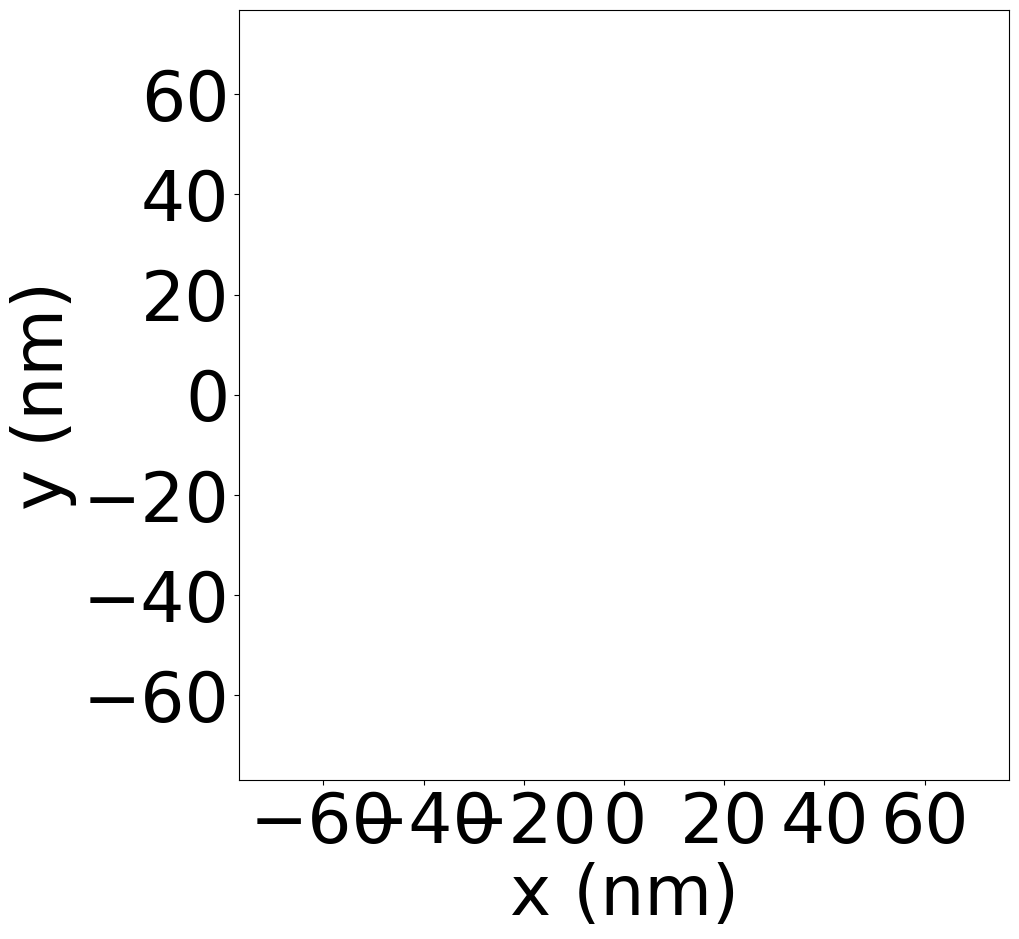

In [12]:
NPC_plotting.AnimateDetail(NPCstest, var, NPCi)

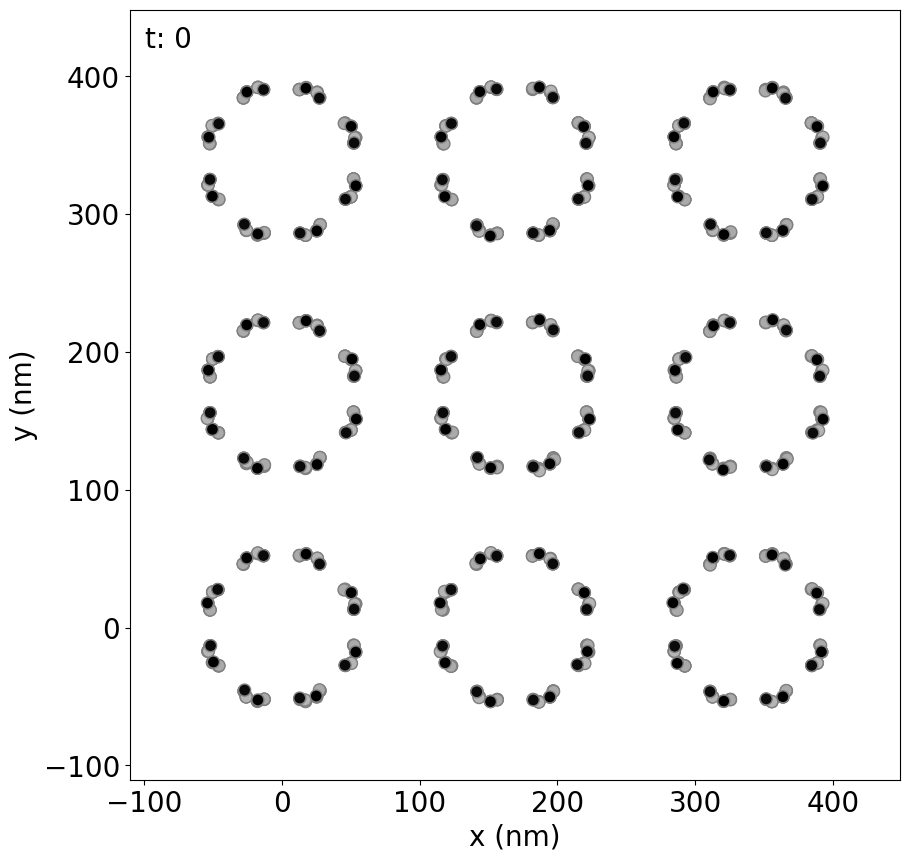

In [15]:
NPC_plotting.AnimateOverview(NPCstest, OffsetNPCs, var)

In [14]:
nameDict, name = exportCSV.names(var)
exportCSV.MakeCSV(var, NPCstest, NPCscoords, nameDict, name, data_dir) 